## Reconstruct 3D model of the mouse embryo by spatially register adjacent 2D slices

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import umap
import os
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib as mpl

import INSPIRE

import warnings
warnings.filterwarnings("ignore")

### Load results

In [2]:
res_path = "Results/INSPIRE_3d_reconstruction"
adata_full = sc.read_h5ad(res_path + "/adata_inspire.h5ad")

### Build the 3D model by spatially register adjacent slices

Spatially register slice 1 with slice 2


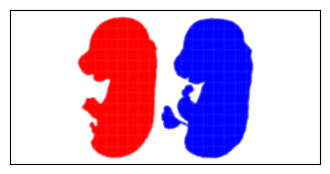

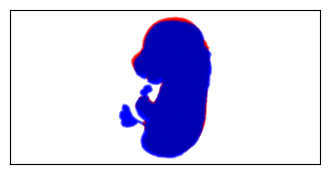

Spatially register slice 2 with slice 3


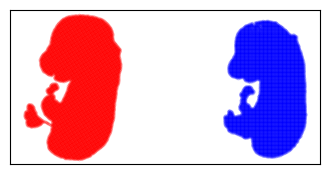

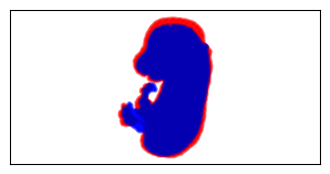

Spatially register slice 3 with slice 4


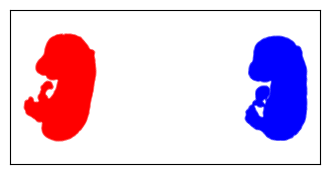

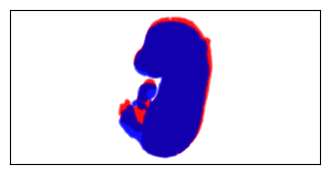

Spatially register slice 4 with slice 5


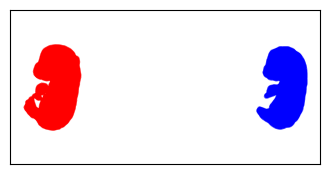

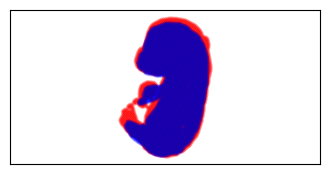

In [3]:
n_slice = len(set(adata_full.obs.slice_label))
adata_st_list = [adata_full[adata_full.obs.slice_label.values.astype(str) == str(i), :].copy() for i in range(n_slice)]
for i_slice in range(n_slice):
    adata_st_list[i_slice].obsm["spatial_regi"] = adata_st_list[i_slice].obsm["spatial"]

n_sample = 20000
for i_slice in range(n_slice-1):
    print("Spatially register slice", str(i_slice+1), "with slice", str(i_slice+2))
    
    # visualize before alignment
    f = plt.figure(figsize=(4,2))
    ax = f.add_subplot(1,1,1)
    ax.axis('equal')
    ax.scatter(adata_st_list[i_slice].obsm["spatial_regi"][:,0], -adata_st_list[i_slice].obsm["spatial_regi"][:,1], c="red", s=.001, alpha=0.5)
    ax.scatter(adata_st_list[i_slice+1].obsm["spatial_regi"][:,0], -adata_st_list[i_slice+1].obsm["spatial_regi"][:,1], c="blue", s=.001, alpha=0.5)
    ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
    plt.show()

    # alignment
    loc0 = adata_st_list[i_slice].obsm["spatial_regi"]
    loc1 = adata_st_list[i_slice+1].obsm["spatial_regi"]

    latent_0 = adata_full[adata_st_list[i_slice].obs.index, :].obsm['latent']
    latent_1 = adata_full[adata_st_list[i_slice+1].obs.index, :].obsm['latent']

    np.random.seed(1234)
    ss_0 = np.random.choice(latent_0.shape[0], size=n_sample, replace=False)
    ss_1 = np.random.choice(latent_1.shape[0], size=n_sample, replace=False)
    loc0 = loc0[ss_0, :]
    loc1 = loc1[ss_1, :]
    latent_0 = latent_0[ss_0, :]
    latent_1 = latent_1[ss_1, :]

    mnn_mat = INSPIRE.utils.acquire_pairs(latent_0, latent_1, k=1, metric='euclidean')
    idx_0 = []
    idx_1 = []
    for i in range(mnn_mat.shape[0]):
        if np.sum(mnn_mat[i, :]) > 0:
            nns = np.where(mnn_mat[i, :] == 1)[0]
            for j in list(nns):
                idx_0.append(i)
                idx_1.append(j)

    loc0_pair = loc0[idx_0, :]
    loc1_pair = loc1[idx_1, :]

    T,_,_ = INSPIRE.utils.best_fit_transform(loc1_pair, loc0_pair)

    loc1 = adata_st_list[i_slice+1].obsm["spatial_regi"]
    loc1_new = INSPIRE.utils.transform(loc1, T)
    adata_st_list[i_slice+1].obsm["spatial_regi"] = loc1_new

    f = plt.figure(figsize=(4,2))
    ax = f.add_subplot(1,1,1)
    ax.axis('equal')
    ax.scatter(adata_st_list[i_slice].obsm["spatial_regi"][:,0], -adata_st_list[i_slice].obsm["spatial_regi"][:,1], c="red", s=.001, alpha=0.5)
    ax.scatter(adata_st_list[i_slice+1].obsm["spatial_regi"][:,0], -adata_st_list[i_slice+1].obsm["spatial_regi"][:,1], c="blue", s=.001, alpha=0.5)
    ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
    plt.show()

In [4]:
# form 3d location

for i_slice in range(n_slice):
    loc_tmp = np.ones((adata_st_list[i_slice].shape[0], 3)) * i_slice
    loc_tmp[:,:2] = adata_st_list[i_slice].obsm["spatial_regi"]
    adata_st_list[i_slice].obsm["spatial_3d"] = loc_tmp

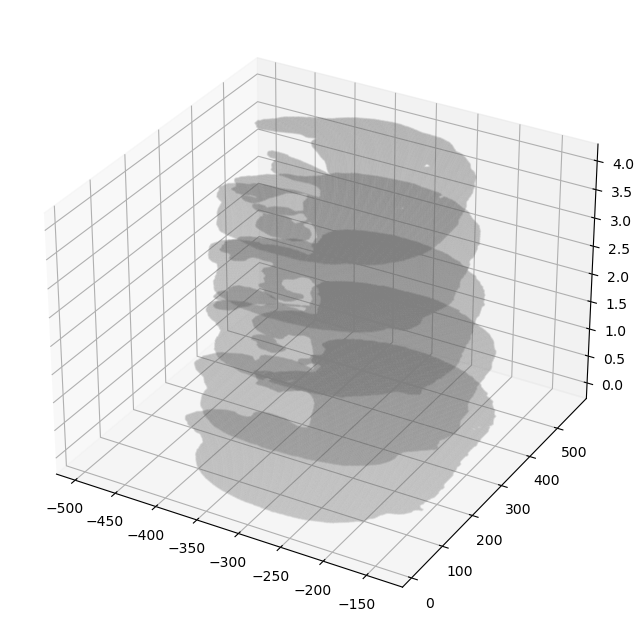

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

size = .05

# draw slices
for i_slice in range(n_slice):
    ax.scatter(adata_st_list[i_slice].obsm["spatial_3d"][:,0], 
               adata_st_list[i_slice].obsm["spatial_3d"][:,1], 
               adata_st_list[i_slice].obsm["spatial_3d"][:,2], s=size, c="gray", alpha=0.1)

plt.show()

### Save result

In [6]:
# save 3d spatial locations
res_path = "Results/INSPIRE_3d_reconstruction"
for i in range(n_slice):
    adata_st_list[i].write(res_path + "/adata_3d_spatial_"+str(i)+".h5ad")